# Data Visualizations Lung Cancer Dataset

In [ ]:
!pip install pynrrd

import os
import pandas as pd
import numpy as np
import nrrd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Library for progress bar
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from scipy.ndimage import zoom

import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Applied AI in biomedicine/Group project - mine
DATA_PATH = 'AI Project 2024-2025'

Mounted at /gdrive
/gdrive/My Drive/Applied AI in biomedicine/Group project - mine


In [ ]:
dataset_lung = pd.read_excel(os.path.join(DATA_PATH, 'dataset_lung.xlsx'))

print(dataset_lung)

                  Full_slice               Nodule  TumorClass
0        pat1_fullslice.nrrd     pat1_nodule.nrrd           5
1        pat2_fullslice.nrrd     pat2_nodule.nrrd           5
2        pat3_fullslice.nrrd     pat3_nodule.nrrd           2
3        pat4_fullslice.nrrd     pat4_nodule.nrrd           5
4        pat5_fullslice.nrrd     pat5_nodule.nrrd           4
...                      ...                  ...         ...
2358  pat2368_fullslice.nrrd  pat2368_nodule.nrrd           2
2359  pat2369_fullslice.nrrd  pat2369_nodule.nrrd           2
2360  pat2387_fullslice.nrrd  pat2387_nodule.nrrd           5
2361  pat2399_fullslice.nrrd  pat2399_nodule.nrrd           5
2362  pat2415_fullslice.nrrd  pat2415_nodule.nrrd           5

[2363 rows x 3 columns]


### Data Loading

This cell reads the `fullslice` and `nodule` `.nrrd` files from the dataset directory. It maps the corresponding labels from the `dataset_lung` dataframe to categorize each image into one of the five tumor classes.


In [ ]:
train_path = os.path.join(DATA_PATH, 'Train')

fullslice_files = [file for file in os.listdir(train_path) if 'fullslice' in file and '.nrrd' in file]
nodule_files = [file for file in os.listdir(train_path) if 'nodule' in file and '.nrrd' in file]

fullslice_images = []
fullslice_labels = []

# Load the fullslice images and corresponding labels
print("Loading Fullslice Images and Labels...")
for file_name in tqdm(fullslice_files, desc="Fullslice Files"):
    fullslice_data, fullslice_header = nrrd.read(os.path.join(train_path, file_name))
    fullslice_images.append(fullslice_data)

    label = dataset_lung.loc[dataset_lung['Full_slice'] == file_name, 'TumorClass'].values[0]
    fullslice_labels.append(label)

nodule_images = []
nodule_labels = []

print("Loading Nodule Images and Labels...")
for file_name in tqdm(nodule_files, desc="Nodule Files"):
    nodule_data, nodule_header = nrrd.read(os.path.join(train_path, file_name))
    nodule_images.append(nodule_data)

    label = dataset_lung.loc[dataset_lung['Nodule'] == file_name, 'TumorClass'].values[0]
    nodule_labels.append(label)

print(f"Total Fullslice Images: {len(fullslice_images)}, Total Labels: {len(fullslice_labels)}")
print(f"Total Nodule Images: {len(fullslice_images)}, Total Labels: {len(nodule_labels)}")

# Benign (classes 1-2-3) vs. malignant (classes 4-5)
labels_dict = {
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
}


Loading Fullslice Images and Labels...


Fullslice Files: 100%|██████████| 2363/2363 [06:08<00:00,  6.41it/s]


Loading Nodule Images and Labels...


Nodule Files: 100%|██████████| 2363/2363 [00:08<00:00, 268.78it/s]

Total Fullslice Images: 2363, Total Labels: 2363
Total Nodule Images: 2363, Total Labels: 2363


### Random Sample Visualization

This cell randomly selects five images each from the `fullslice` and `nodule` datasets. The selected images are displayed in grayscale along with their tumor class labels.


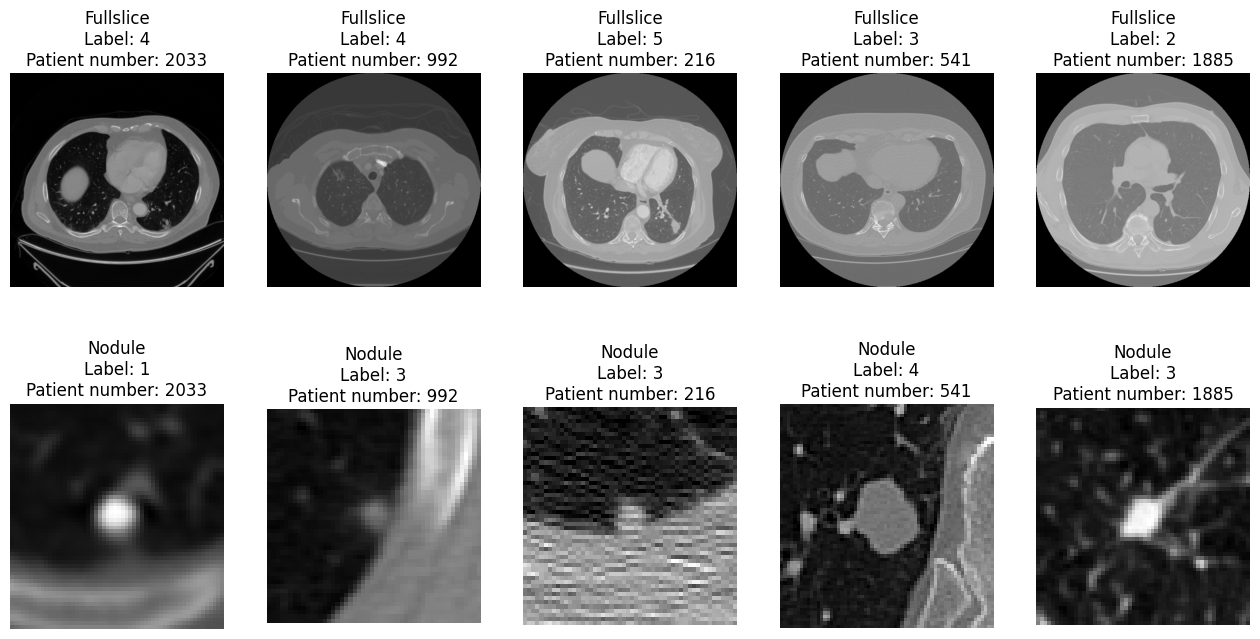

In [ ]:
num_samples = 5
indices = np.random.choice(len(fullslice_images), num_samples, replace=False)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(fullslice_images[idx], cmap='gray')
    plt.title(f"Fullslice\nLabel: {labels_dict[fullslice_labels[idx]]}\nPatient number: {idx}")
    plt.axis('off')

    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(nodule_images[idx], cmap='gray')
    plt.title(f"Nodule\nLabel: {labels_dict[nodule_labels[idx]]}\nPatient number: {idx}")
    plt.axis('off')
plt.show()

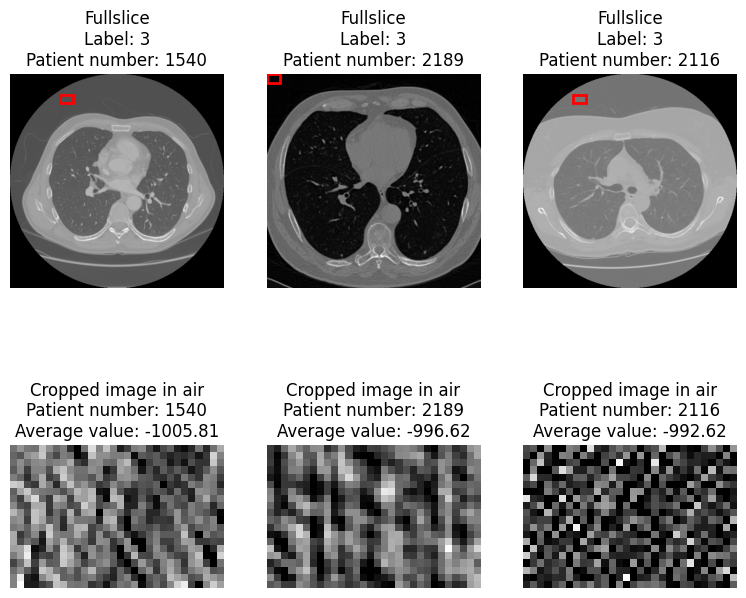

In [ ]:
import matplotlib.patches as patches
slices= [1540, 2189, 2116]
plt.figure(figsize=(16, 8))
x_min, x_max = [120, 1, 120], [150, 31, 150]
y_min, y_max = [50, 1, 50], [70, 21, 70]
for i, idx in enumerate(slices):
    image=fullslice_images[idx]
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Fullslice\nLabel: {labels_dict[fullslice_labels[idx]]}\nPatient number: {idx}")
    plt.axis('off')

    ax = plt.gca()
    rect = patches.Rectangle(
        (x_min[i], y_min[i]),  # Coordinate in alto a sinistra
        x_max[i] - x_min[i],   # Larghezza del rettangolo
        y_max[i] - y_min[i],   # Altezza del rettangolo
        linewidth=2, edgecolor='red', facecolor='none'  # Stile del rettangolo
    )
    ax.add_patch(rect)

    cropped_image = image[y_min[i]:y_max[i], x_min[i]:x_max[i]]
    fullslice_images[idx]
    plt.subplot(2, num_samples, i + 1 + num_samples)
    plt.imshow(cropped_image, cmap='gray')
    plt.title(f"Cropped image in air\nPatient number: {idx}\nAverage value: {np.mean(cropped_image):.2f}")
    plt.axis('off')
plt.show()

### Image sizes
Here I show image sizes of `fullslice` and `nodule` images.

In [ ]:
# Get the sizes of fullslice images
fullslice_sizes = [img.shape for img in fullslice_images]
nodule_sizes = [img.shape for img in nodule_images]

# Find unique sizes
unique_fullslice_sizes = set(fullslice_sizes)
unique_nodule_sizes = set(nodule_sizes)

print(f"Unique Fullslice Image Sizes: {unique_fullslice_sizes}")
print(f"Unique Nodule Image Sizes: {unique_nodule_sizes}")

# Check if there are different sizes
if len(unique_fullslice_sizes) > 1:
    print("Fullslice images have different sizes.")
else:
    print("All Fullslice images have the same size.")

if len(unique_nodule_sizes) > 1:
    print("Nodule images have different sizes.")
else:
    print("All Nodule images have the same size.")

Unique Fullslice Image Sizes: {(512, 512)}
Unique Nodule Image Sizes: {(67, 59), (55, 57), (107, 95), (47, 53), (86, 72), (70, 64), (59, 64), (99, 109), (48, 45), (48, 54), (77, 99), (63, 61), (81, 78), (52, 51), (74, 66), (93, 79), (74, 84), (85, 84), (55, 52), (96, 90), (47, 48), (55, 61), (59, 59), (78, 72), (70, 68), (59, 68), (48, 49), (80, 81), (92, 83), (62, 60), (52, 46), (73, 78), (81, 91), (51, 50), (51, 59), (66, 66), (85, 79), (88, 81), (55, 56), (59, 54), (59, 63), (77, 71), (69, 67), (77, 80), (48, 53), (69, 85), (80, 85), (79, 126), (80, 103), (54, 51), (62, 64), (73, 64), (54, 60), (73, 82), (51, 54), (95, 97), (88, 67), (96, 80), (55, 51), (47, 47), (55, 60), (99, 94), (80, 62), (69, 71), (61, 67), (62, 59), (91, 95), (102, 95), (54, 55), (73, 77), (94, 109), (51, 49), (51, 58), (84, 92), (95, 92), (96, 75), (76, 69), (65, 69), (107, 93), (47, 51), (58, 57), (50, 53), (69, 66), (50, 62), (61, 62), (69, 75), (54, 50), (62, 63), (83, 95), (54, 59), (51, 53), (87, 74), (9

### Class and Binary Class Distribution

This cell visualizes:
1. The distribution of tumor classes (`1-5`) in the `fullslice` dataset.
2. The binary classification distribution (`Benign` vs `Malignant`), where classes `1, 2, 3` are mapped to `Benign` and `4, 5` to `Malignant`.
Both distributions are shown as bar plots.


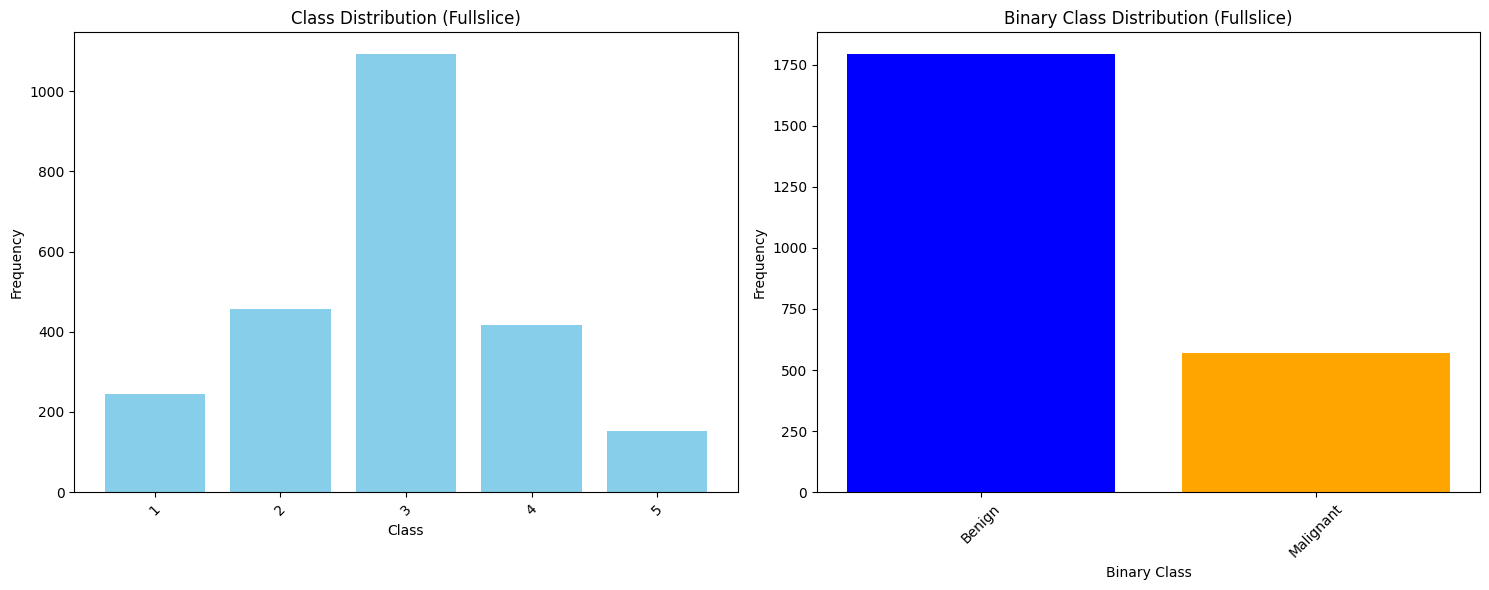

In [ ]:
fullslice_class_counts = Counter(fullslice_labels)

binary_fullslice_labels = ["Benign" if label in [1, 2, 3] else "Malignant" for label in fullslice_labels]
binary_fullslice_class_counts = Counter(binary_fullslice_labels)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar([labels_dict[key] for key in fullslice_class_counts.keys()], fullslice_class_counts.values(), color='skyblue')
plt.title("Class Distribution (Fullslice)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(binary_fullslice_class_counts.keys(), binary_fullslice_class_counts.values(), color=['blue', 'orange'])
plt.title("Binary Class Distribution (Fullslice)")
plt.xlabel("Binary Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### PCA Visualization

This cell resizes all nodule images to a uniform shape `(50, 50)` and applies PCA (Principal Component Analysis) to reduce the image data into 2D components. Two scatter plots are generated:
1. PCA visualization of `fullslice` images categorized by tumor class.
2. PCA visualization of `nodule` images categorized by tumor class.


In [ ]:
target_shape = (50, 50)


def resize_image(image, target_shape):
    zoom_factors = [target_dim / current_dim for target_dim, current_dim in zip(target_shape, image.shape)]
    return zoom(image, zoom_factors, order=1)


resized_nodule_images = [resize_image(img, target_shape) for img in nodule_images]

fullslice_flattened = np.array([img.flatten() for img in fullslice_images])
nodule_flattened = np.array([img.flatten() for img in resized_nodule_images])

pca_fullslice = PCA(n_components=2).fit_transform(fullslice_flattened)
pca_nodule = PCA(n_components=2).fit_transform(nodule_flattened)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for label in np.unique(fullslice_labels):
    plt.scatter(
        pca_fullslice[np.array(fullslice_labels) == label, 0],
        pca_fullslice[np.array(fullslice_labels) == label, 1],
        label=labels_dict[label],
        alpha=0.7
    )
plt.title("PCA - Fullslice Images")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

# Nodule PCA Plot
plt.subplot(1, 2, 2)
for label in np.unique(nodule_labels):
    plt.scatter(
        pca_nodule[np.array(nodule_labels) == label, 0],
        pca_nodule[np.array(nodule_labels) == label, 1],
        label=labels_dict[label],
        alpha=0.7
    )
plt.title("PCA - Nodule Images")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

### t-SNE Visualization

This cell applies t-SNE (t-Distributed Stochastic Neighbor Embedding) to reduce image data into 2D components for better cluster visualization. Three scatter plots are created:

1. Combined t-SNE plot showing both `fullslice` and `nodule` images.
2. Separate t-SNE plot for `fullslice` images categorized by tumor class.
3. Separate t-SNE plot for `nodule` images categorized by tumor class.


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
reduced_fullslice_tsne = tsne.fit_transform(fullslice_flattened)
reduced_nodule_tsne = tsne.fit_transform(nodule_flattened)

plt.figure(figsize=(12, 6))
for label in np.unique(fullslice_labels):
    plt.scatter(
        reduced_fullslice_tsne[np.array(fullslice_labels) == label, 0],
        reduced_fullslice_tsne[np.array(fullslice_labels) == label, 1],
        label=f"Fullslice - {labels_dict[label]}",
        alpha=0.7
    )

for label in np.unique(nodule_labels):
    plt.scatter(
        reduced_nodule_tsne[np.array(nodule_labels) == label, 0],
        reduced_nodule_tsne[np.array(nodule_labels) == label, 1],
        label=f"Nodule - {labels_dict[label]}",
        alpha=0.7,
        marker="x"
    )

plt.title("t-SNE - Fullslice vs. Nodule")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for label in np.unique(fullslice_labels):
    plt.scatter(
        reduced_fullslice_tsne[np.array(fullslice_labels) == label, 0],
        reduced_fullslice_tsne[np.array(fullslice_labels) == label, 1],
        label=f"Fullslice - {labels_dict[label]}",
        alpha=0.7
    )
plt.title("t-SNE - Fullslice Images")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for label in np.unique(nodule_labels):
    plt.scatter(
        reduced_nodule_tsne[np.array(nodule_labels) == label, 0],
        reduced_nodule_tsne[np.array(nodule_labels) == label, 1],
        label=f"Nodule - {labels_dict[label]}",
        alpha=0.7,
        marker="x"
    )
plt.title("t-SNE - Nodule Images")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

### Pixel Intensity Distribution

This cell visualizes the pixel intensity distribution for `fullslice` and `nodule` datasets:

1. Histogram of raw pixel intensities.
2. Histogram with logarithmic scaling on the y-axis to highlight intensity variations.
3. Log-transformed pixel intensities for both datasets, plotted as histograms to further explore differences in pixel intensity distributions.


In [ ]:
fullslice_pixel_values = np.concatenate([img.flatten() for img in fullslice_images])
nodule_pixel_values = np.concatenate([img.flatten() for img in nodule_images])

print('Min pixel value fullslice, nodules:', np.min(fullslice_pixel_values), np.min(nodule_pixel_values))
print('Max pixel value fullslice, nodules:', np.max(fullslice_pixel_values), np.max(nodule_pixel_values))

plt.figure(figsize=(6, 4))
plt.hist(fullslice_pixel_values, bins=100, alpha=0.7, label="Fullslice", color='blue')
plt.hist(nodule_pixel_values, bins=50, alpha=0.7, label="Nodule", color='orange')
plt.title("Pixel Intensity Distribution: Fullslice vs. Nodule")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(fullslice_pixel_values, bins=100, alpha=0.7, label="Fullslice", color='blue')
plt.hist(nodule_pixel_values, bins=50, alpha=0.7, label="Nodule", color='orange')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title("Pixel Intensity Distribution: Fullslice vs. Nodule (Log Scale)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Log Frequency")
plt.legend()
plt.show()

fullslice_pixel_values = fullslice_pixel_values[fullslice_pixel_values > 0]
nodule_pixel_values = nodule_pixel_values[nodule_pixel_values > 0]

log_fullslice_pixel_values = np.log1p(fullslice_pixel_values)
log_nodule_pixel_values = np.log1p(nodule_pixel_values)

plt.figure(figsize=(6, 4))
plt.hist(log_fullslice_pixel_values, bins=100, alpha=0.7, label="Fullslice", color='blue')
plt.hist(log_nodule_pixel_values, bins=50, alpha=0.7, label="Nodule", color='orange')
plt.title("Log-Transformed Pixel Intensity Distribution: Fullslice vs. Nodule")
plt.xlabel("Log Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()



In [ ]:
# Thresholds
a = 6000  # Upper threshold
b = -4000  # Lower threshold

# Array to store the indices of images that meet the condition
problematic_images = []

# Iterate over all the images
for idx, image in enumerate(fullslice_images):
    # Check if any pixel in the image is greater than 'a' or less than 'b'
    if np.any(image > a) or np.any(image < b):
        problematic_images.append(idx)  # Save the index of the image

# Print the result
print(f"Images with pixels > {a} or < {b}: {problematic_images}")

Images with pixels > 6000 or < -4000: [546, 1406, 1408, 1430, 1463, 1468, 1469, 1534, 1544, 1576, 1577]


In [ ]:
#image 34 seems like an outlier
problematic_images[25]

34

In [ ]:
len(problematic_images)

11

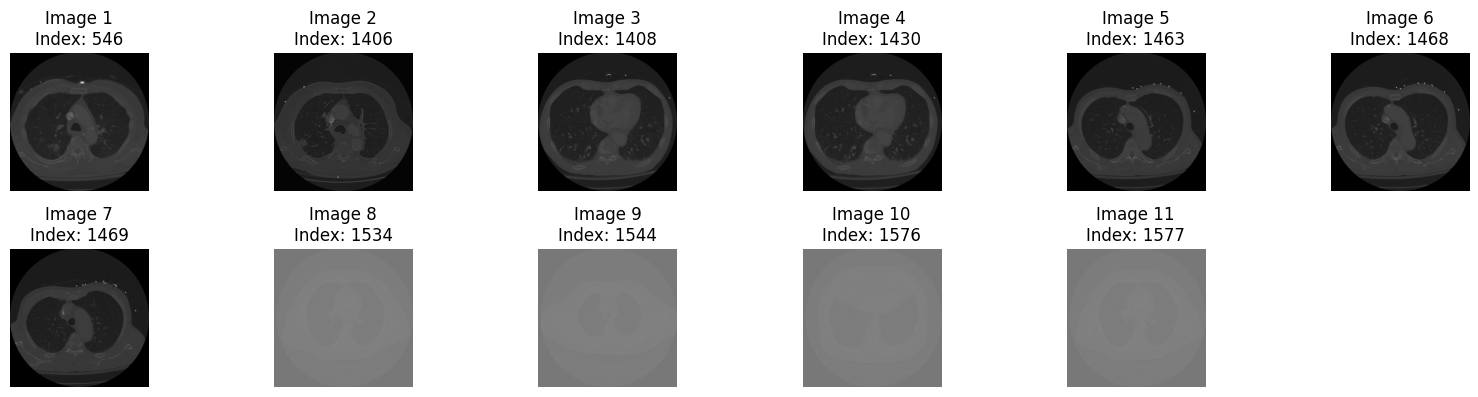

In [ ]:
# Ensure that only the first 20 indices are used
selected_indices = problematic_images[:20]

plt.figure(figsize=(16, 8))

# Iterate over the first 20 indices in problematic_images
for i, idx in enumerate(selected_indices):
    image = fullslice_images[idx]

    # Display the image in a subplot
    plt.subplot(4, 6, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image {i+1}\nIndex: {idx}")
    plt.axis('off')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


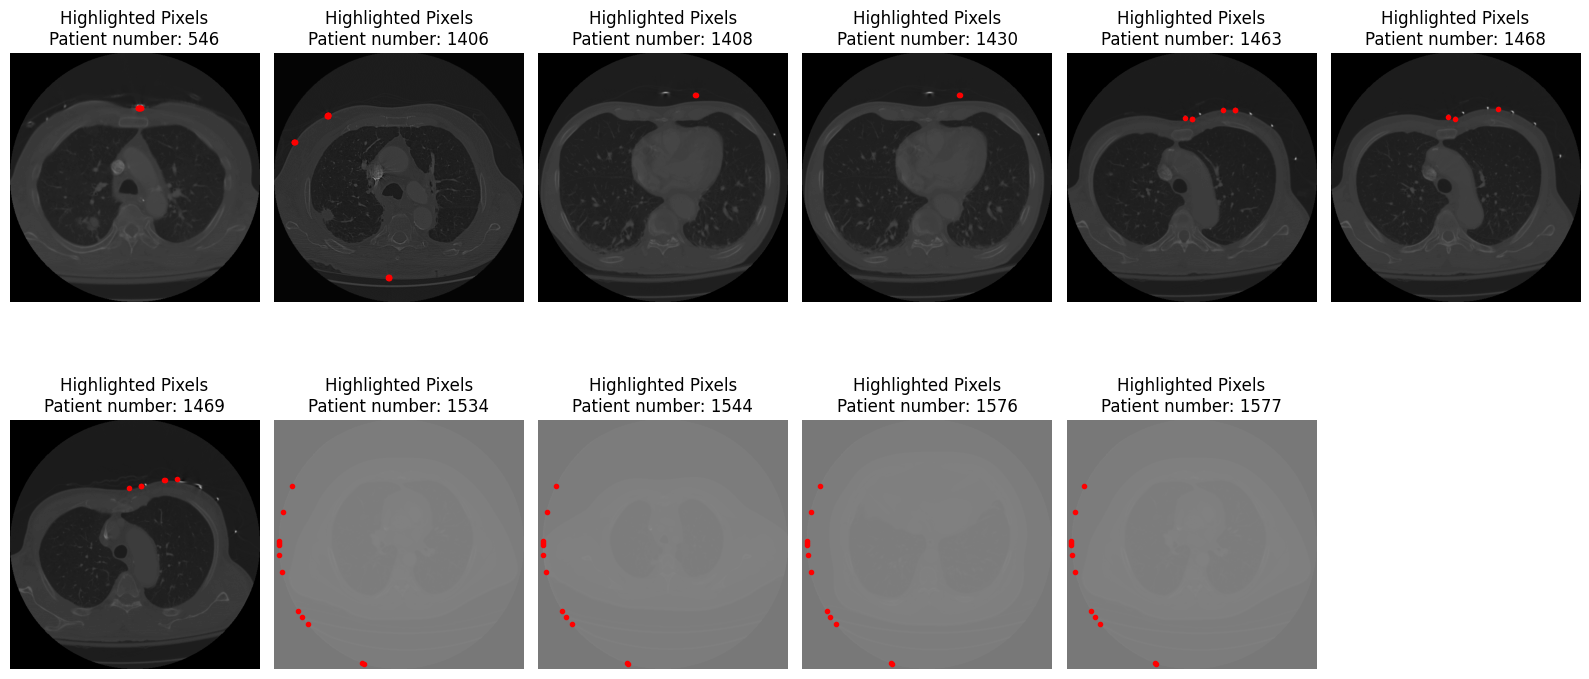

In [ ]:
# Define the number of columns in each row
num_columns = 6

# Calculate the number of rows needed to display all the images
# Use selected_indices instead of slices to determine the number of rows
num_rows = (len(selected_indices) + num_columns - 1) // num_columns  # This is a ceiling division

plt.figure(figsize=(16, 8))

# Iterate over the selected indices
for i, idx in enumerate(selected_indices):
    # Fullslice image
    image = fullslice_images[idx]

    # Determine the row and column for the subplot
    row = i // num_columns  # Row index
    col = i % num_columns   # Column index

    # Create the subplot for the highlighted pixels only
    plt.subplot(num_rows, num_columns, row * num_columns + col + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Highlighted Pixels\nPatient number: {idx}")
    plt.axis('off')

    # Find the pixels that satisfy the threshold condition
    red_pixels = np.where((image > a) | (image < b))  # Indices of pixels that meet the condition

    # Plot red dots at the positions of the pixels that satisfy the condition
    for y, x in zip(*red_pixels):
        plt.plot(x, y, 'ro', markersize=3)  # Plot red dot at (x, y) positions

# Show the results
plt.tight_layout()
plt.show()

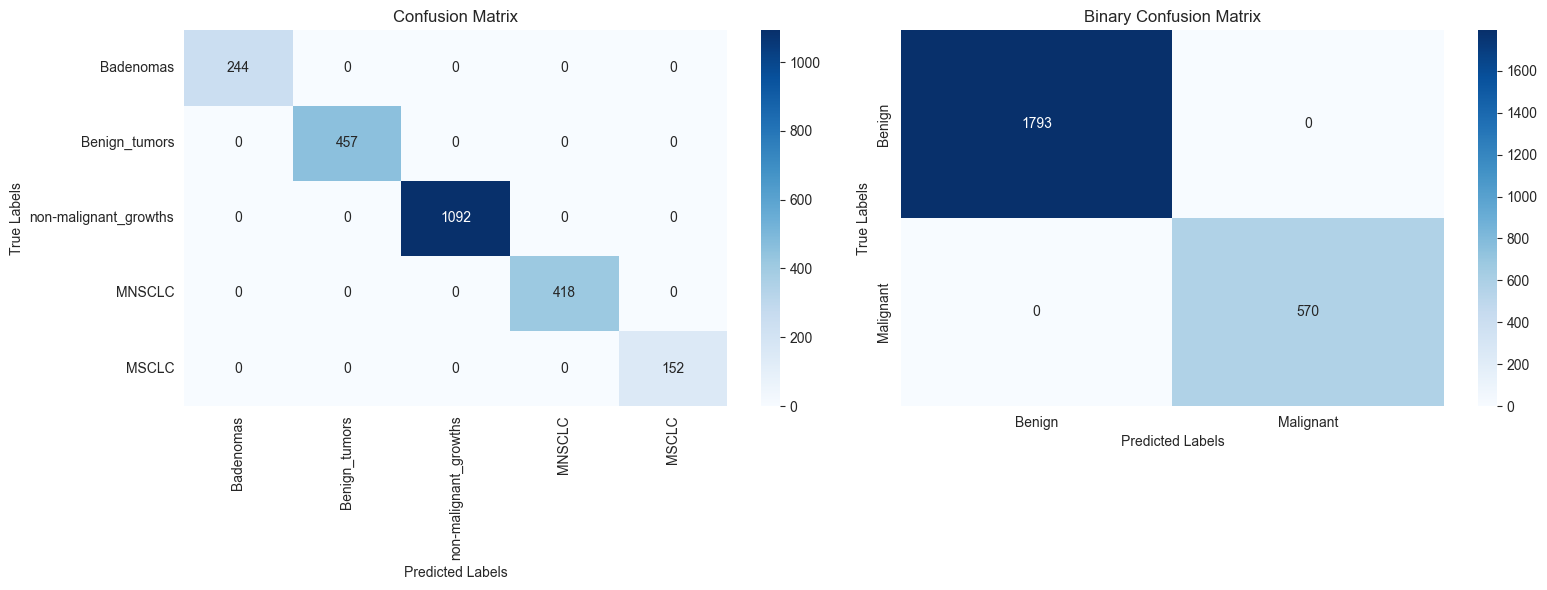

In [ ]:
cm = confusion_matrix(fullslice_labels, fullslice_labels, labels=[1, 2, 3, 4, 5])
class_names = ["Badenomas", "Benign_tumors", "non-malignant_growths", "MNSCLC", "MSCLC"]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

cm_binary = confusion_matrix(binary_fullslice_labels, binary_fullslice_labels, labels=["Benign", "Malignant"])
binary_class_names = ["Benign", "Malignant"]

plt.subplot(1, 2, 2)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', xticklabels=binary_class_names,
            yticklabels=binary_class_names)
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()


## Define model

In [ ]:

input_shape = [512,512,1]
output_shape = [5]

backbone = keras.applications.EfficientNetB2(
              include_top=False,
              weights="imagenet",
              input_shape=input_shape,
              name="efficientnetb2",
          )

# This is to transf. learning 1st step
backbone.trainable = False

augmentation = tf.keras.Sequential([
                tfkl.RandomFlip("horizontal"),
                tfkl.RandomTranslation(0.2, 0.2)
            ], name='preprocessing')

def build_model(backbone=backbone,augmentation=augmentation,, input_shape=input_shape, plot=True):


    backbone.trainable = False

    inputs = tfk.Input(shape=input_shape, name='input_layer')

    if augmentation:
       x = augmentation(inputs)
    else:
       x = inputs

    x = backbone(x)
    x = tfkl.Dropout(0.3, name='dropout')(x)
    outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)
    tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    if plot
      tl_model.summary(expand_nested=True)
      tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

    return tl_model

tl_model = build_model()


## Training

In [ ]:
BATCH_SIZE = 64
EPOCHS = 200

history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

model_filename = 'Pets_MobileNetV3S_' + str(final_val_accuracy) + '.keras'
tl_model.save(model_filename)

del tl_model